In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import numpy as np
import torchvision
from torch.optim import Adam
from sklearn.model_selection import KFold
import torch.nn.functional as F
import os

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [4]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        
        # Load pre-trained ResNet-18 model
        resnet18 = models.resnet18(pretrained=True)
        
        # Remove the fully connected layers at the end
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        
        # Add a global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Modify the number of output features of the last layer
        in_features = resnet18.fc.in_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [5]:
model=ResNet18(num_classes=3).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s] 


In [6]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
# Define BCE loss function
loss_function = nn.CrossEntropyLoss()

In [7]:
from torch.optim.lr_scheduler import StepLR
# Define the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [8]:
# Define number of epochs and folds
num_epochs = 5
num_folds = 5

In [9]:
# Path for training directory
train_path = '/kaggle/input/k-fold-train/png_dataset/train'

In [10]:
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transformer)
from torch.utils.data import Subset

In [11]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=64, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=32, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        
        train_accuracy = train_accuracy / len(train_index)
        train_loss = train_loss / len(train_index)
        
        # Validation loop
        model.eval()
        
        val_accuracy = 0.0
        val_loss = 0.0
        
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()* images.size(0)  # Accumulate the loss
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            
        # Compute average loss and accuracy
        val_loss /= len(val_index)
        val_accuracy = val_accuracy / len(val_index)
        
        # Step the scheduler
        scheduler.step()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        
        # Save the best model
        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), 'best_model.pth')
            best_accuracy = val_accuracy
            
print(f"Best Validation Accuracy: {best_accuracy}")

Fold 1/5
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [1/5], Train Loss: 1.108, Train Accuracy: 0.355, Val Loss: 1.150, Validation Accuracy: 0.341
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [2/5], Train Loss: 0.887, Train Accuracy: 0.553, Val Loss: 1.056, Validation Accuracy: 0.619
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [3/5], Train Loss: 0.624, Train Accuracy: 0.734, Val Loss: 0.531, Validation Accuracy: 0.784
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [4/5], Train Loss: 0.495, Train Accuracy: 0.800, Val Loss: 0.504, Validation Accuracy: 0.797
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [5/5], Train Loss: 0.441, Train Accuracy: 0.825, Val Loss: 0.492, Validation Accuracy: 0.819
Fold 2/5
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [1/5], Train Loss: 0.408, Train Accuracy: 0.840, Val Loss: 0.408, Validation Accuracy: 0.845
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch [2/5], Train Loss: 0.385, Train 

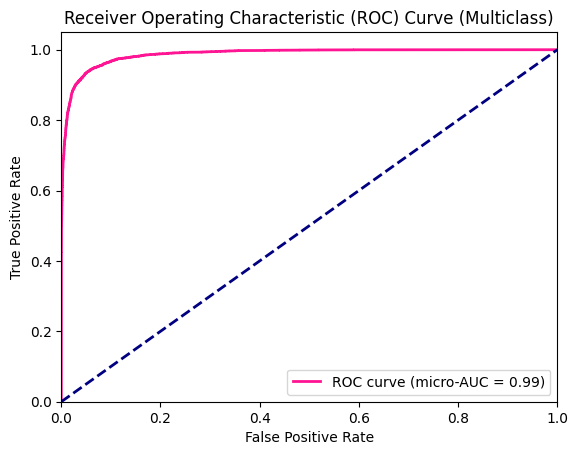

In [12]:
test_path='/kaggle/input/k-fold-train/png_dataset/test'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming model is already defined and moved to GPU if available

# Assuming transformer is defined

# Assuming test_loader is defined

y_score_list = []
y_true_list = []

# Evaluate model
model.eval()
for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = model(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()